# Test MH harmonic

In [1]:
import os, sys, time
import argparse
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.random as random
import toml
import numpyro
from functools import partial
import micmac
from micmac import *
from fgbuster.observation_helpers import *

from jax import config
current_path = os.path.abspath('')
sys.path.append(current_path)
sys.path.append(os.path.dirname(os.path.dirname(current_path))+'/tutorials/')

config.update("jax_enable_x64", True)

In [2]:
path_home_test_playground = os.path.dirname(current_path) + '/'

In [3]:
working_directory_path = os.path.abspath('') + '/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'
directory_additional_params = working_directory_path + 'additional_params/'

# path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'


In [4]:
num_jobs = 5

file_ver = 'corr_fullsky_LB_v104_v2a_gpu_{}_{}'
path_additional_params = directory_additional_params + 'add_gpu_corr_fullsky_LB_v2a.toml'
## Not converged at all

file_ver = 'corr_fullsky_LB_v104_v2b_gpu_{}_{}'
path_additional_params = directory_additional_params + 'add_gpu_corr_fullsky_LB_v2b.toml'
## Also not converged at all

file_ver = 'corr_fullsky_v104_v1a_gpu_{}_{}'
path_additional_params = directory_additional_params + 'add_gpu_corr_fullsky_v1a.toml'
## r seems to have converged, but not all chains agree, at least 1/5 is a bit further than the rest, 
## and the 4 others agree up to delta_r = 10^-4
## Still bit unclear for B_f, need to test Gelman-Rubin, with harmonic, and verify all input maps are the same
## wrong run, should be with r=0 not r=0.01

file_ver = 'corr_fullsky_v104_v1b_gpu_{}_{}'
path_additional_params = directory_additional_params + 'add_gpu_corr_fullsky_v1b.toml'
## r seems to have converged, but not all chains agree, at least 1/5 is a bit further than the rest, 
## and the 4 others agree up to delta_r = 10^-4
## Still bit unclear for B_f, need to test Gelman-Rubin, with harmonic, and verify all input maps are the same

num_jobs = 1
file_ver = 'test_corr_fullsky_v1f_{}_{}'
path_additional_params = directory_additional_params + 'test_add_corr_fullsky_v0f.toml'
### Good run SO with precond !!!
## 4000 iterations [5:57:08<00:00,  5.36s/it] - LOCAL

num_jobs = 1
file_ver = 'test_corr_fullsky_LB_v1c_{}_{}'
path_additional_params = directory_additional_params + 'test_add_corr_fullsky_LB_v0c.toml'
## Good run LB !!! Seems converged everywhere !!! 
# 4000 iterations, [17:57:55<00:00, 16.17s/it] - LOCAL

num_jobs = 5
file_ver = 'corr_cutsky_v104_v1b_{}_{}'
path_additional_params = directory_additional_params + 'add_corr_cutsky_v1b.toml'
# ## All good ? Probably need to converge a bit more though for B_f
# ## Cutsky -> Verify first how Harmonic will treat it !!!!!!
# use_mask = True

In [5]:
save_chains = False
# save_chains = True

In [6]:
# reduction_Fisher = 10
reduction_Fisher = 1

In [7]:
with open(path_additional_params) as f:
    dictionary_additional_parameters = toml.load(f)
f.close()

reduction_noise = dictionary_additional_parameters['reduction_noise']
# factor_Fisher = dictionary_additional_parameters['factor_Fisher']
# relative_treshold = dictionary_additional_parameters['relative_treshold']
# sigma_gap = dictionary_additional_parameters['sigma_gap']
fgs_model = dictionary_additional_parameters['fgs_model']
# initial_guess_r = dictionary_additional_parameters['initial_guess_r']
# use_nhits = dictionary_additional_parameters['use_nhits']
# name_mask = dictionary_additional_parameters['name_mask']
use_mask = dictionary_additional_parameters['use_mask']
use_nhits = dictionary_additional_parameters['use_nhits']
name_toml = dictionary_additional_parameters['name_toml']
seed_realization_input = dictionary_additional_parameters['seed_realization_input']

print("Using toml file: ", name_toml)

Using toml file:  corr_cutsky_v1b.toml


In [8]:
path_toml_file = directory_toml_file + name_toml

In [9]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

# if 'corr_fullsky_v104_v1a_gpu_' in file_ver:
#     MICMAC_sampler_obj.r_true = 0.01

No yaml file found in given path:  
No spatial variability case
root
  nside_spv
    default: [0]
    f1
      default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
      b4
        default: None
    f2
      default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
      b4
        default: None
root
  nside_spv
    default: [0]
    f1
      default: [0]
      b1
        default: [0]
      b2
        default: [0]
      b3
        default: [0]
      b4
        default: [0]
    f2
      default: [0]
      b1
        default: [0]
      b2
        default: [0]
      b3
        default: [0]
      b4
        default: [0]


In [10]:
fgs_model_ = 'd0s0'
instr_name = MICMAC_sampler_obj.instrument_name #'SO_SAT'

path_Fisher = path_home_test_playground + f'Fisher_matrix_{MICMAC_sampler_obj.instrument_name}_EB_model_{fgs_model_}_noise_True_seed_42_lmin2_lmax128.txt'
try :
    Fisher_matrix = np.loadtxt(path_Fisher)
except:
    print("Fisher matrix not found !", flush=True)
    Fisher_matrix = np.loadtxt(path_home_test_playground + f'Fisher_matrix_{MICMAC_sampler_obj.instrument_name}_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt')


In [11]:
directory_mask = "/Users/mag/Documents/PHD1Y/Masks/"
path_mask = directory_mask + "mask_SAT_apodized.fits"

if use_mask:
    apod_mask = hp.ud_grade(hp.read_map(path_mask),nside_out=MICMAC_sampler_obj.nside)

    template_mask = np.copy(apod_mask)
    if use_nhits:
        template_mask[template_mask<relative_treshold] = 0
        inverse_nhits_mask = np.copy(template_mask)
        inverse_nhits_mask[template_mask>0] = 1/template_mask[template_mask>0]

        mask = np.copy(template_mask)
        mask[template_mask>0] = 1
        mask[template_mask==0] = 0
    else:
        mask = np.copy(apod_mask)
        mask[apod_mask>0] = 1
        mask[apod_mask==0] = 0
        template_mask = mask
else:
    template_mask = np.ones_like(MICMAC_sampler_obj.mask)

In [12]:
# get instrument from public database
instrument = get_instrument(instr_name)
depth_p_array = np.array(instrument['depth_p'])/dictionary_additional_parameters['reduction_noise']

In [13]:
covariance_B_f_to_use = np.linalg.inv(Fisher_matrix)[:-1, :-1]/reduction_Fisher

MICMAC_Harm_obj = create_Harmonic_MICMAC_sampler_from_MICMAC_sampler_obj(MICMAC_sampler_obj, depth_p_array,
                                                    covariance_B_f=covariance_B_f_to_use)

MICMAC_Harm_obj.step_size_r = np.sqrt(np.linalg.inv(Fisher_matrix)[-1, -1])

No yaml file found in given path:  
No spatial variability case


In [14]:
NSIDE = MICMAC_Harm_obj.nside

noise_seed = MICMAC_Harm_obj.seed
# instr_name = MICMAC_Harm_obj.instrument_name

# # get instrument from public database
# instrument = get_instrument(instr_name)

# get input freq maps
np.random.seed(noise_seed)

freq_maps_fgs = get_observation(instrument, fgs_model, nside=NSIDE, noise=True)[:, 1:, :]   # keep only Q and U

_, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_Harm_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]

indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_Harm_obj.nstokes]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Calculating spectra from CAMB !
Calculating spectra from CAMB !


## Retrieving input map

In [15]:
initial_freq_maps = []
input_cmb_maps = []
MICMAC_all_r_samples = []
MICMAC_all_params_mixing_matrix_samples = []

for job in range(num_jobs):
    initial_freq_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_data.npy'
    initial_freq_maps.append(np.load(initial_freq_maps_path))

    initial_cmb_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_cmb_data.npy'
    input_cmb_maps.append(np.load(initial_cmb_maps_path))

    if MICMAC_sampler_obj.sample_r_Metropolis:
        all_r_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_r_samples.npy'
        MICMAC_all_r_samples.append(np.load(all_r_samples_path))

    all_params_mixing_matrix_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_params_mixing_matrix_samples.npy'
    MICMAC_all_params_mixing_matrix_samples.append(np.load(all_params_mixing_matrix_samples_path))

initial_freq_maps = np.array(initial_freq_maps)
input_cmb_maps = np.array(input_cmb_maps)
if MICMAC_sampler_obj.sample_r_Metropolis:
    MICMAC_all_r_samples = np.array(MICMAC_all_r_samples)
MICMAC_all_params_mixing_matrix_samples = np.array(MICMAC_all_params_mixing_matrix_samples)

In [16]:
f_sky = np.sum(template_mask)/len(template_mask)

input_freq_maps = initial_freq_maps[0]*template_mask/np.sqrt(f_sky)

In [17]:
for i in range(initial_freq_maps.shape[0]):
    print(initial_freq_maps[0][initial_freq_maps[i]-initial_freq_maps[0]!=0])

[]
[]
[]
[]
[]


In [18]:
# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_Harm_obj.n_components, pos_special_freqs=MICMAC_Harm_obj.pos_special_freqs, spv_nodes_b=MICMAC_Harm_obj.spv_nodes_b)

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_Harm_obj.n_components, nside=MICMAC_Harm_obj.nside, spv_nodes_b=MICMAC_Harm_obj.spv_nodes_b, params=init_params, pos_special_freqs=MICMAC_Harm_obj.pos_special_freqs)
mixing_matrix_sampled = mixing_matrix_obj.get_B()

len_pos_special_freqs = len(mixing_matrix_obj.pos_special_freqs)


In [19]:
theoretical_r0_total = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)
theoretical_r1_tensor = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)

c_ell_approx = np.zeros((3,MICMAC_Harm_obj.lmax+1))
c_ell_approx[0,MICMAC_Harm_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_Harm_obj.lmin:] = theoretical_r0_total[1,:]

red_cov_approx_matrix = get_reduced_matrix_from_c_ell_jax(c_ell_approx)[MICMAC_Harm_obj.lmin:]

In [20]:
final_values_params_mixing_matrix = MICMAC_all_params_mixing_matrix_samples.mean(axis=(0,1)).ravel(order='F')
final_values_r = MICMAC_all_r_samples.mean()

## Starting MH

In [21]:
dimension_free_param_B_f = 2*(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)

In [22]:
# all_samples_Pixel_B_f_r = np.zeros((MICMAC_sampler_obj.number_iterations_sampling+1, dimension_free_param_B_f+1))
# all_samples_Pixel_B_f_r[:, :dimension_free_param_B_f] = MICMAC_all_params_mixing_matrix_samples.reshape(-1, dimension_free_param_B_f, order='F')
# all_samples_Pixel_B_f_r[:, dimension_free_param_B_f] = MICMAC_all_r_samples

# covariance_B_f_r_pixel = np.cov(all_samples_Pixel_B_f_r.T)
# diag_step_size = np.diag(sp.linalg.sqrtm(covariance_B_f_r_pixel))

In [23]:
# diag_step_size

In [25]:
# first_guess_r, final_values_r

In [26]:
first_guess = final_values_params_mixing_matrix.ravel(order='F')
first_guess_r = final_values_r

# first_guess = np.abs(final_values_params_mixing_matrix.ravel(order='F') + np.random.uniform(-10,10)*diag_step_size[:dimension_free_param_B_f])
# first_guess_r = np.abs(final_values_r + np.random.uniform(-10,10)*diag_step_size[dimension_free_param_B_f])

# first_guess = np.abs(final_values_params_mixing_matrix.ravel(order='F') + np.random.uniform(-10,10)*np.diag(np.sqrt(covariance_B_f_to_use))[:dimension_free_param_B_f])
# first_guess_r = np.abs(final_values_r + np.random.uniform(-10,10)*MICMAC_Harm_obj.step_size_r)

In [27]:
MICMAC_Harm_obj.number_iterations_sampling = 10000
MICMAC_Harm_obj.number_iterations_sampling = 5000
MICMAC_Harm_obj.number_iterations_sampling = 2000
# MICMAC_Harm_obj.number_iterations_sampling = 1000

In [28]:
MICMAC_Harm_obj.perform_harmonic_MH(input_freq_maps, c_ell_approx, first_guess, initial_guess_r=first_guess_r,
                                    covariance_B_f_r=None, theoretical_r0_total=theoretical_r0_total, theoretical_r1_tensor=theoretical_r1_tensor)

Disabling chex !!!


Covariance B_f, r [[ 1.57489654e-08  2.71276909e-09  2.36835419e-09  1.51939102e-09
  -3.07091465e-09 -2.22079266e-10 -1.71572069e-10 -1.08678732e-10
   0.00000000e+00]
 [ 2.71276909e-09  3.60992230e-09  3.23728759e-09  2.20123320e-09
  -2.22092335e-10 -2.67787336e-10 -2.20384248e-10 -1.65635733e-10
   0.00000000e+00]
 [ 2.36835419e-09  3.23728759e-09  3.35867742e-09  2.28038258e-09
  -1.71583988e-10 -2.20383790e-10 -2.75123127e-10 -2.01145001e-10
   0.00000000e+00]
 [ 1.51939102e-09  2.20123320e-09  2.28038258e-09  3.39944797e-09
  -1.08682729e-10 -1.65630220e-10 -2.01140112e-10 -5.35936148e-10
   0.00000000e+00]
 [-3.07091465e-09 -2.22092335e-10 -1.71583988e-10 -1.08682729e-10
   2.22105731e-09  3.30205693e-10  2.84475588e-10  1.82264589e-10
   0.00000000e+00]
 [-2.22079266e-10 -2.67787336e-10 -2.20383790e-10 -1.65630220e-10
   3.30205693e-10  4.34708081e-10  3.86465385e-10  2.65474299e-10
   0.00000000e+00]
 [-1.71572069e-10 -2.20384248e-10 -2.75123127e-10 -2.01140112e-10
   2.84475

sample: 100%|██████████| 2000/2000 [01:44<00:00, 19.17it/s]

End of MH iterations for harmonic run in 1.7420485178629557 minutes, now saving results !
Test [[0.33951188 0.02898336 0.00948903 ... 0.12890617 0.44067005 0.00980683]
 [0.33948137 0.02894022 0.0094026  ... 0.12893587 0.44068196 0.01096246]
 [0.33948137 0.02894022 0.0094026  ... 0.12893587 0.44068196 0.01096246]
 ...
 [0.34073601 0.03096805 0.01138355 ... 0.12990815 0.44138898 0.11295352]
 [0.34073601 0.03096805 0.01138355 ... 0.12990815 0.44138898 0.11295352]
 [0.34073393 0.03098519 0.01136068 ... 0.12992488 0.44140449 0.11193682]]
Test size (2000, 9)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.34      0.00      0.34      0.34      0.34     12.04      1.01
Param:0[1]      0.03      0.00      0.03      0.03      0.03      4.52      1.26
Param:0[2]      0.01      0.00      0.01      0.01      0.01      4.42      1.30
Param:0[3]      0.00      0.00      0.00      0.00      0.00      6.93      1.09
Param:0[4]      0.01      0.00      0.01      0.01      0.01      7.33      1.01
Param:0[5]      0.05      0.00      0.05      0.05      0.05      5.08      1.25
Param:0[6]      0.13      0.00      0.13      0.13      0.13      4.46      1.30
Param:0[7]      0.44      0.00      0.44      0.44      0.44     11.35      1.03
Param:0[8]      0.10      0.03      0.11      0.05      0.12      5.13      1.26



In [29]:
MICMAC_Harm_obj.all_samples_r.shape

(2000,)

In [30]:
MICMAC_Harm_obj.all_params_mixing_matrix_samples.shape

(2000, 4, 2)

In [31]:
MICMAC_Harm_obj.all_params_mixing_matrix_samples.std(axis=0)

Array([[0.00068403, 0.00032235],
       [0.00067775, 0.00024581],
       [0.00063841, 0.00025995],
       [0.00039262, 0.00014145]], dtype=float64)

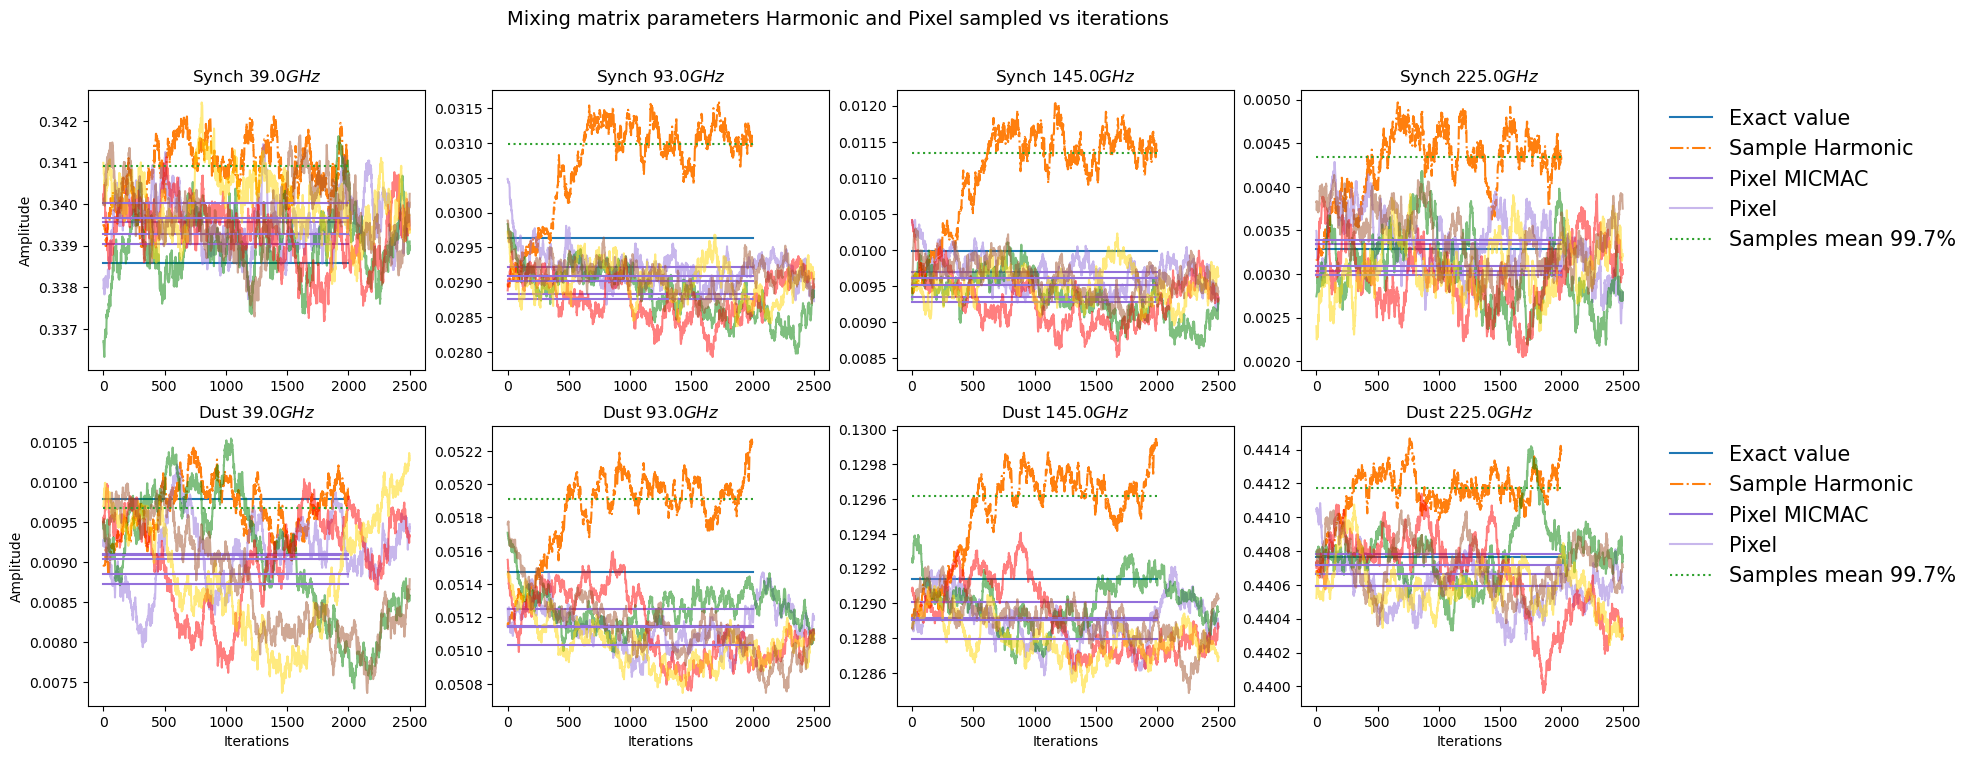

In [32]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_Harm_obj.lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])

all_B_f_sample_synch = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,:,0]
all_B_f_sample_dust = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,:,1]

MICMAC_B_f_sample_synch = MICMAC_all_params_mixing_matrix_samples[...,0]
MICMAC_B_f_sample_dust = MICMAC_all_params_mixing_matrix_samples[...,1]
final_MICMAC_pixel_B_f_synch = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,0]
final_MICMAC_pixel_B_f_dust = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,1]

frequency_array = np.array(instrument['frequency'])

alpha_value = .5
color_MICMAC_pixel = 'mediumpurple'
color_MICMAC_pixel_list = ['mediumpurple', 'green', 'red', 'gold', 'sienna']

if MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs < 10:
    plt.figure(figsize=(20,8))
    plt.suptitle('Mixing matrix parameters Harmonic and Pixel sampled vs iterations', fontsize=14)
    # plt.subplot(121)

    for i in range(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs):
        plt.subplot(201+len(frequency_Bf)*10+i)
        plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [init_params[i],init_params[i]], label='Exact value')
        plt.plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_synch[:,i], '-.', label='Sample Harmonic')

        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_synch[0,i],final_MICMAC_pixel_B_f_synch[0,i]], color=color_MICMAC_pixel, label='Pixel MICMAC')
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_synch[0,:,i], color=color_MICMAC_pixel_list[0], alpha=alpha_value, label='Pixel')
        for j in range(1,MICMAC_B_f_sample_synch.shape[0]):
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_synch[j,:,i], color=color_MICMAC_pixel_list[j], alpha=alpha_value)
            plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_synch[j,i],final_MICMAC_pixel_B_f_synch[j,i]], color=color_MICMAC_pixel)
        
        n_sigma = 3
        transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
        cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
        mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
        std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

        mean_value = all_B_f_sample_synch[:,i].mean()
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

        # plt.yscale('log')
        # plt.xlabel('Iterations')
        if i == 0:
            plt.ylabel('Amplitude')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

    # plt.figure(figsize=(20,8))
    # plt.subplot(122)
    for i in range(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs):
        plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
        # plt.subplot(201+len(frequency_Bf)*10+i)
        plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [init_params[i+np.size(frequency_Bf)],init_params[i+np.size(frequency_Bf)]], label='Exact value')
        plt.plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_dust[:,i], '-.', label='Sample Harmonic')

        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_dust[0,i],final_MICMAC_pixel_B_f_dust[0,i]], color=color_MICMAC_pixel, label='Pixel MICMAC')
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_dust[0,:,i], color=color_MICMAC_pixel_list[0], alpha=alpha_value,label='Pixel')
        for j in range(1,MICMAC_B_f_sample_dust.shape[0]):
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_dust[j,:,i], color=color_MICMAC_pixel_list[j], alpha=alpha_value)
            plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_dust[j,i],final_MICMAC_pixel_B_f_dust[j,i]], color=color_MICMAC_pixel)
        
        n_sigma = 3
        transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
        cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
        mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
        std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

        mean_value = all_B_f_sample_dust[:,i].mean()
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
        # plt.yscale('log')
        plt.xlabel('Iterations')
        if i == 0:
            plt.ylabel('Amplitude')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

    plt.show()

In [33]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_Harm_obj.lmin


frequency_Bf = np.array(instrument['frequency'][1:-1])
dimension_free_param_B_f = 2*(MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)

alpha_value = .5
color_MICMAC_pixel = 'mediumpurple'
color_MICMAC_pixel_list = ['mediumpurple', 'green', 'red', 'gold', 'sienna']

MICMAC_B_f_sample_synch = MICMAC_all_params_mixing_matrix_samples[...,0]
MICMAC_B_f_sample_dust = MICMAC_all_params_mixing_matrix_samples[...,1]
final_MICMAC_pixel_B_f_synch = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,0]
final_MICMAC_pixel_B_f_dust = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,1]

burn_in_iterations = MICMAC_Harm_obj.number_iterations_sampling//2
cond = np.arange(MICMAC_Harm_obj.number_iterations_sampling) > burn_in_iterations

for job in range(num_jobs):
    all_B_f_sample_synch = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,:,0]
    all_B_f_sample_dust = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,:,1]

    frequency_array = np.array(instrument['frequency'])


    if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
        number_columns = 4
        number_rows = (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)//number_columns + 1

        # plt.figure(figsize=(20,8))
        fig, ax = plt.subplots(number_rows, number_columns, figsize=(20,8))
        useless_plots = number_rows*number_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*number_columns)//number_columns
            num_col = (number_rows*number_columns)%number_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

        fig.suptitle(f"Mixing matrix synch parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
        # plt.subplot(121)

        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//number_columns
            num_col = i%number_columns
            ax[num_row, num_col].set_title((f'Synch ${frequency_Bf[i]} GHz$'))
            # plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
            
            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [init_params[i],init_params[i]], label='Exact value')
            ax[num_row, num_col].plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_synch[:,i], '-.', label='Sample Harmonic')

            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_synch[0,i],final_MICMAC_pixel_B_f_synch[0,i]], color=color_MICMAC_pixel, label='Pixel MICMAC')
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_synch[0,:,i], color=color_MICMAC_pixel_list[0], alpha=alpha_value, label='Pixel')
            for j in range(1,MICMAC_B_f_sample_synch.shape[0]):
                ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_synch[j,:,i], color=color_MICMAC_pixel_list[j], alpha=alpha_value)
                ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_synch[j,i],final_MICMAC_pixel_B_f_synch[j,i]], color=color_MICMAC_pixel)
        
            # n_sigma = 3
            # transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
            # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
            std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

            mean_value = all_B_f_sample_synch[:,i].mean()
            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

            # plt.yscale('log')
            # plt.xlabel('Iterations')
            # ax[num_row, num_col].set_xlabel('Iterations')
            if i == 0:
                # plt.ylabel('Amplitude')
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-number_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

        # plt.figure(figsize=(20,8))
        # plt.subplot(122)
        fig, ax = plt.subplots(number_rows, number_columns, figsize=(20,8))
        useless_plots = number_rows*number_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*number_columns)//number_columns
            num_col = (number_rows*number_columns)%number_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])


        fig.suptitle(f"Mixing matrix dust parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
        
        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//number_columns
            num_col = i%number_columns
            ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [init_params[i+dimension_free_param_B_f//2],init_params[i+dimension_free_param_B_f//2]], label='Exact value')
            ax[num_row, num_col].plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_dust[:,i], '-.', label='Sample Harmonic')

            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_dust[0,i],final_MICMAC_pixel_B_f_dust[0,i]], color=color_MICMAC_pixel, label='Pixel MICMAC')
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_dust[0,:,i], color=color_MICMAC_pixel_list[0], alpha=alpha_value,label='Pixel')
            for j in range(1,MICMAC_B_f_sample_dust.shape[0]):
                ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_dust[j,:,i], color=color_MICMAC_pixel_list[j], alpha=alpha_value)
                ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_dust[j,i],final_MICMAC_pixel_B_f_dust[j,i]], color=color_MICMAC_pixel)

            # n_sigma = 3
            # transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
            # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
            std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

            mean_value = all_B_f_sample_dust[:,i].mean()
            ax[num_row, num_col].plot([0,MICMAC_Harm_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
            # plt.yscale('log')
            
            if i == 0:
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-number_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

    plt.show()

(999,) 2000


/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


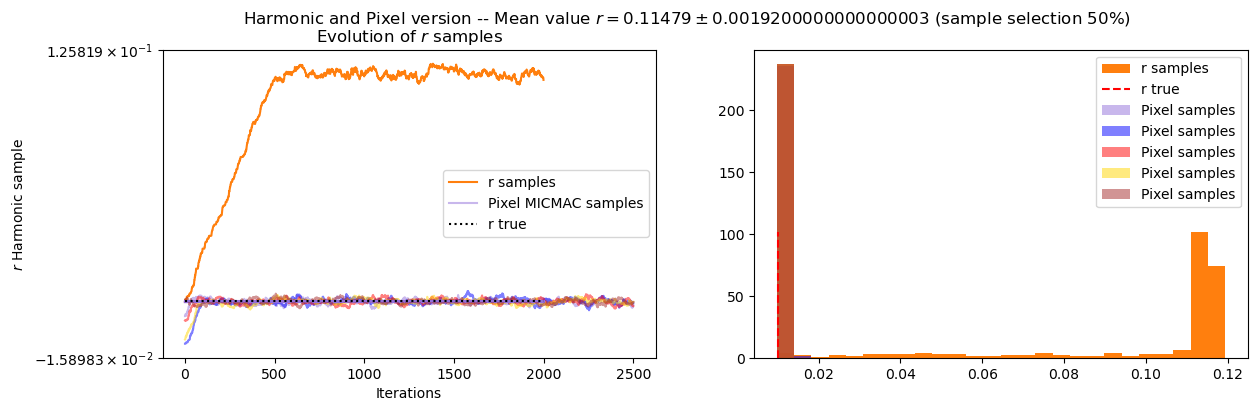

In [34]:
plt.figure(figsize=(14,4))

# n_sigma = 3

all_r_samples = MICMAC_Harm_obj.all_samples_r

burn_in_iterations = MICMAC_Harm_obj.number_iterations_sampling//2
# cond = np.abs((all_r_samples - all_r_samples.mean())/(all_r_samples.std())) < n_sigma
cond = np.arange(MICMAC_Harm_obj.number_iterations_sampling) > burn_in_iterations
print(all_r_samples[cond].shape, MICMAC_Harm_obj.number_iterations_sampling)
mean_r = np.round(all_r_samples[cond].mean(), decimals=5)
std_r = np.round(all_r_samples[cond].std(), decimals=5)

alpha_value = .5
color_MICMAC_pixel = 'mediumpurple'
color_MICMAC_pixel_list = ['mediumpurple', 'blue', 'red', 'gold', 'brown']

plt.suptitle(f"Harmonic and Pixel version -- Mean value $r = {mean_r} \pm {std_r}$ (sample selection 50%) ")

final_MICMAC_pixel_r = MICMAC_all_r_samples.mean(axis=1)

plt.subplot(121)
plt.plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_r_samples, color='tab:orange', label='r samples')

plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_all_r_samples[0], color=color_MICMAC_pixel_list[0], label='Pixel MICMAC samples', alpha=alpha_value)
plt.plot([0, MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_r[0],final_MICMAC_pixel_r[0]], color=color_MICMAC_pixel)
for i in range(1,MICMAC_all_r_samples.shape[0]):
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_all_r_samples[i], color=color_MICMAC_pixel_list[i], alpha=alpha_value)

    plt.plot([0, MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_r[i],final_MICMAC_pixel_r[i]], color=color_MICMAC_pixel)

plt.plot([0, MICMAC_Harm_obj.number_iterations_sampling], [MICMAC_Harm_obj.r_true,MICMAC_Harm_obj.r_true], 'k:', label='r true')


plt.xlabel("Iterations")
plt.ylabel('$r$ Harmonic sample')
plt.title(r'Evolution of $r$ samples')
if MICMAC_Harm_obj.r_true > 0:
    plt.yscale('symlog')
else:
    plt.yscale('log')
plt.legend()

plt.subplot(122)
hist_values, bins_value, _ = plt.hist(all_r_samples, bins='rice', label='r samples', color='tab:orange', density=True)
plt.plot([MICMAC_Harm_obj.r_true,MICMAC_Harm_obj.r_true], [0,hist_values.max()], 'r--', label='r true')
for job in range(num_jobs):
    _, _, _ = plt.hist(MICMAC_all_r_samples[job], bins=bins_value, color=color_MICMAC_pixel_list[job], alpha=alpha_value, density=True, label='Pixel samples')
# plt.plot([final_MICMAC_pixel_r[0],final_MICMAC_pixel_r[0]], [0,hist_values.max()], color=color_MICMAC_pixel, label='Pixel')
# for i in range(1, MICMAC_all_r_samples.shape[0]):
#     plt.plot([final_MICMAC_pixel_r[i],final_MICMAC_pixel_r[i]], [0,hist_values.max()], color=color_MICMAC_pixel)
    
plt.legend()
plt.show()

In [35]:
if save_chains:
    print("Saving chains Harm !!!!!")
    initial_freq_maps_path = directory_save_file+file_ver.format('Harm', MICMAC_Harm_obj.number_iterations_sampling)+"_initial_data.npy"
    print("Saving Harmonic input freq maps in ", initial_freq_maps_path)
    np.save(initial_freq_maps_path, input_freq_maps)

    initial_cmb_maps_path = directory_save_file+file_ver.format('Harm', MICMAC_Harm_obj.number_iterations_sampling)+"_initial_cmb_data.npy"
    print("Saving Harmonic input cmb maps in ", initial_cmb_maps_path)
    np.save(initial_cmb_maps_path, input_cmb_maps)

    all_r_samples_path = directory_save_file+file_ver.format('Harm', MICMAC_Harm_obj.number_iterations_sampling)+"_all_r_samples.npy"
    print("Saving Harmonic r samples in ", all_r_samples_path)
    np.save(all_r_samples_path, MICMAC_Harm_obj.all_samples_r)

    all_params_mixing_matrix_samples_path = directory_save_file+file_ver.format('Harm', MICMAC_Harm_obj.number_iterations_sampling)+"_all_params_mixing_matrix_samples.npy"
    print("Saving Harmonic params mixing matrix in ", all_params_mixing_matrix_samples_path)
    np.save(all_params_mixing_matrix_samples_path, MICMAC_Harm_obj.all_params_mixing_matrix_samples)


In [36]:
all_r_samples.shape

(2000,)

In [37]:
jnp.cov(jnp.expand_dims(all_r_samples,axis=0), rowvar=True)

Array(0.00074822, dtype=float64)

In [38]:
all_r_samples.var()

Array(0.00074784, dtype=float64)

In [39]:
(jnp.sum(all_r_samples*all_r_samples) - all_r_samples.shape[0]*(all_r_samples.mean())**2)/(all_r_samples.shape[0]-1)

Array(0.00074822, dtype=float64)

In [40]:
MICMAC_Harm_obj.all_params_mixing_matrix_samples.shape

(2000, 4, 2)

In [41]:
all_samples_B_f_r = np.zeros((MICMAC_Harm_obj.number_iterations_sampling, (MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)*2+1))

all_samples_B_f_r[:,-1] = all_r_samples
all_samples_B_f_r[:,:-1] = MICMAC_Harm_obj.all_params_mixing_matrix_samples.reshape((MICMAC_Harm_obj.number_iterations_sampling, (MICMAC_Harm_obj.n_frequencies-len_pos_special_freqs)*2))

In [42]:
jnp.cov(all_samples_B_f_r, rowvar=False) - jnp.cov(all_samples_B_f_r.T)

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float64)

In [43]:
np.diag(sp.linalg.sqrtm(jnp.cov(all_samples_B_f_r.T)))

array([5.37936759e-04, 2.65303283e-04, 2.27228629e-04, 7.84496651e-05,
       2.04946845e-04, 9.98453248e-05, 2.17852487e-04, 8.79771853e-05,
       2.73335054e-02])

In [44]:
np.diag(sp.linalg.sqrtm(np.linalg.pinv(np.loadtxt(path_Fisher))))

array([1.22719235e-04, 4.72984090e-05, 4.44084763e-05, 5.23546882e-05,
       4.28340683e-05, 1.62270766e-05, 1.52905384e-05, 1.82529746e-05,
       5.55036342e-04])